<a href="https://colab.research.google.com/github/alejandraberbesi/apparel_image/blob/master/src/apparel_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This dataset is downloaded from kaggle using the Kaggle API**

In [0]:
'''!pip install kaggle==1.5.6
!kaggle -v'''

In [0]:
!mkdir -p ~/.kaggle  

In [0]:
#after uploading kaggle file with my credentials in directory
!cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d airplane2230/apparel-image-dataset-2

 99% 247M/249M [00:03<00:00, 52.6MB/s]
100% 249M/249M [00:03<00:00, 66.5MB/s]


In [0]:
! unzip -q -n /content/apparel-image-dataset-2.zip #extracting content from a compressed folder

In [0]:
from fastai.vision import *

In [0]:
train_set = pd.read_csv('/content/train.csv')
val_set=pd.read_csv('/content/val.csv')
test_set=pd.read_csv('/content/test.csv')

In [0]:
#creating a unique dataframe with all the sets
df=pd.concat([train_set,val_set,test_set], keys=['train', 'val','test'], names=['previous_set', 'id'])
df=df.iloc[:,1:] #deleting a column that won't be used

In [9]:
print("train_set length = {} ".format(len(train_set)))
print("df length = {} ".format(len(df)))

train_set length = 5578 
df length = 11385 


In [12]:
df.iloc[5577,:] #index of last train_set row

image     ./clothes_dataset\white_dress\d58b9b44af525933...
black                                                     0
blue                                                      0
brown                                                     0
green                                                     0
red                                                       0
white                                                     1
dress                                                     1
shirt                                                     0
pants                                                     0
shorts                                                    0
shoes                                                     0
Name: (train, 5577), dtype: object

In [0]:
#changing labels' format and the strings with the images location
df=df.replace(1.0, pd.Series(df.columns, df.columns))
df=df.replace(0.0,'')
df['labels'] = df.iloc[:,1:12].apply(lambda row:' '.join(row.values.astype(str)), axis=1) #creating one column with multi-labels
df['labels'] = df['labels'].replace('\s+', ' ', regex=True) #deleting spaces between words
df['labels'] = df['labels'].replace('^\s', '', regex=True) #deleting initial space
df['labels'] = df['labels'].replace('\s$', '', regex=True) #deleting final space
df['image'] = df['image'].replace('^./', '', regex=True)
df['image']=df['image'].replace(r'\\', '/', regex=True)

In [0]:
df=df.drop(df.iloc[:,1:12], axis = 1) #deleting redundant columns

In [15]:
df

image        labels
previous_set id                                                                   
train        0     clothes_dataset/blue_shorts/256d854b55ac32ea4d...   blue shorts
             1     clothes_dataset/red_pants/584f778aece14f07c2f3...     red pants
             2     clothes_dataset/green_pants/ec543ca241cefb2b3a...   green pants
             3     clothes_dataset/brown_shorts/c8db9e0f7010592fa...  brown shorts
             4     clothes_dataset/white_dress/551373c80717c5b056...   white dress
...                                                              ...           ...
test         3411  clothes_dataset/black_shirt/d76faa497083f1f6c7...   black shirt
             3412  clothes_dataset/blue_pants/691dacb1274608390c7...    blue pants
             3413  clothes_dataset/blue_pants/9b5ac8ce3de1d5219f4...    blue pants
             3414  clothes_dataset/black_pants/7db76af76fe19a0157...   black pants
             3415  clothes_dataset/green_shirt/e45d9991211fa46ab5...   green shirt

[11385 rows x 2 columns]

In [0]:
tfms = get_transforms(max_rotate=50,max_zoom=1) #transformations applied to the images

In [0]:
np.random.seed(100)
data = (ImageList.from_df(df=df,path='/content',cols=0) #path of the images
       .split_by_idx(list(range(5578,11385))) #validation_set indexes
       .label_from_df(cols=1,label_delim=' ') #to split labels with ';'
       .transform(tfms, size=128) 
       .databunch()
       .normalize(imagenet_stats)) # to normalize the dataset based on the stats of the RGB channels from the ImageNet dataset

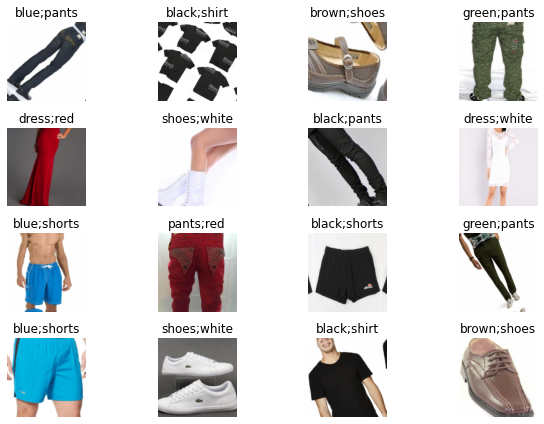

In [18]:
data.show_batch(rows=4, figsize=(9,6))

In [0]:
arch = models.resnet34

In [27]:
data.c #amount of possible labels

11

In [28]:
data.classes #all possible labels

['black',
 'blue',
 'brown',
 'dress',
 'green',
 'pants',
 'red',
 'shirt',
 'shoes',
 'shorts',
 'white']

In [0]:
#every class probability is compared with a threshold (0.5) and the target labels are assigned accordingly
learn = cnn_learner(data, arch, metrics=accuracy_thresh)

In [0]:
learn.lr_find()

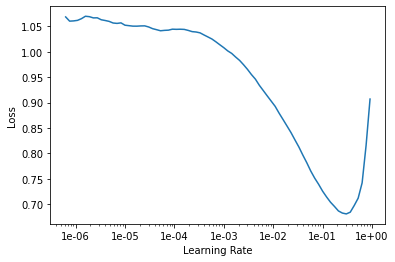

In [23]:
learn.recorder.plot()

In [0]:
lr = 0.01 #number closest to steepest slope

In [25]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.393489,0.097141,0.965841,01:52
1,0.159482,0.058782,0.979194,01:51
2,0.096182,0.043209,0.985049,01:50
3,0.075647,0.039719,0.986286,01:49
4,0.061094,0.038211,0.987132,01:49


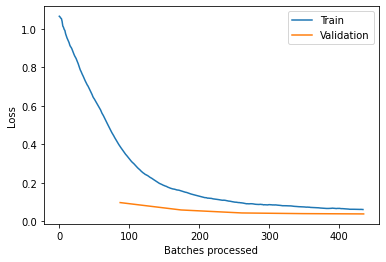

In [26]:
learn.recorder.plot_losses()